# Opdracht Regressie


De bedoeling van regressie is om op basis van een getraind model voorspellingen te doen van continue waarden.
Concreet komt het er op neer dat er een verband gezocht wordt tussen één of meerdere features en een zekere output variabele y. Dit verband is een (multidimensionale) curve van de vorm $y = \theta_n x_n + ... \theta_1 x_1 + \theta_0$. De vector X is de set van features en de set van $\theta$'s noemen we de parameters.

De doelstellingen van deze opdracht zijn:
- Data kunnen inlezen en verwerken met de pandas library.
- Eenvoudige statistische analyses uitvoeren op de data met als doel het detecteren van de consistenties van de data en het kunnen inschatten van de samenhang tussen de verschillende features en de output variabele.  
- Correct kunnen opsplitsen van de data in een training set en test set.
- Weten hoe je data normaliseert.
- Trainen van een regressiemodel.
- Kunnen evalueren van het getrainde regressiemodel via verschillende metrics zoals MAE en de $R^2$-score.
- Feature engineering toepassen: manueel of automatisch extra (hogere orde features) toevoegen.
- Kunnen detecteren van overfitting en underfitting.
- L1 en L2 regularisatie toepassen om te regelen tussen overfitting en underfitting.

In [1]:
%matplotlib inline
import datetime
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML libraries inladen

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Voor statistische data visualisatie
import seaborn as sns; sns.set(color_codes=True)

## 1. Wijnkwaliteit

Van heel wat (rode en witte) portugese Vinho Verde wijnen(http://www.vinhoverde.pt/en/) werden een aantal chemische parameters opgemeten. Ook werd aan een panel van wijnexperten gevraagd om de wijnen een kwaliteitsscore op smaak te geven tussen 0 en 10.

Een overzicht van de features: 1- fixed acidity | 2 - volatile acidity | 3 - citric acid | 4 - residual sugar | 5 - chlorides | 6 - free sulfur dioxide | 7 - total sulfur dioxide | 8 - density | 9 - pH | 10 - sulphates |11 - alcohol

De output of target variabele is 'quality', de kwaliteitsscore (score tussen 0 en 10).

De bedoeling is om via meervoudige regressie zo betrouwbaar mogelijk de kwaliteitsscore van een wijn te kunnen voorspellen op basis van de chemische parameters ervan.

In [2]:
# Dataset vanuit een csv bestand inlezen in een pandas dataframe.
dataset = pd.read_csv('winequality-red.csv',';')
dataset.shape

(1599, 12)

In [3]:
# Eerste rijen van de dataset
dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Statistische vooranalyse

- Geef een samenvattende tabel met beschrijvende centrum- en spreidingswaarden via de describe funtie van pandas.
- Ga na of de dataset ontbrekende waarden bevat.
- Is er op het eerste zicht sprake van uitschieters? Niettegenstaande dit voor multidimensionele gecorreleerde data niet volledig opgaat mag je bij deze opdracht uitschieters aanzien als featurewaarden die meer dan 5 standaardafwijkingen rond het gemiddelde gelegen zijn.
- Maak een correlatie heatmap. Welke features lijken het meest invloed te hebben op de kwaliteitsscore? Zijn er features die onderling sterk gecorreleerd zijn. Als je 5 features zou willen weglaten, welke zouden dit zijn? Verklaar waarom. Bij deze vraag is de verklaring belangrijk.
- Maak een pairplot, bekijk deze aandachtig en formuleer enkele conclusies. Zijn er verbanden te leggen tussen wat je ziet op de pairplot en op de correlatie heatmap?

- Geef een samenvattende tabel met beschrijvende centrum- en spreidingswaarden via de describe funtie van pandas.

In [4]:
dataset.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


- Ga na of de dataset ontbrekende waarden bevat.

In [5]:
dataset.isnull().sum()

# Neen, er zijn geen ontbrekende waarden

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
# Weglaten van de uitschieters:
# Normaal gezien alleen maar doen als je weet dat de uitschieters het gevolg zijn van 
# inconsistenties of fouten.

from scipy import stats
dataset = dataset[(np.abs(stats.zscore(dataset)) < 5).all(axis=1)]
dataset.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000
mean,8.317715,0.528383,0.265950,2.464987,0.082637,15.717587,45.666881,0.996719,3.316393,0.647150,10.443036,5.641849
std,1.752651,0.177769,0.191775,1.066407,0.025365,10.239842,31.521324,0.001862,0.150868,0.139792,1.063903,0.807062
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995585,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996720,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.089000,21.000000,61.000000,0.997820,3.400000,0.720000,11.100000,6.000000
max,15.900000,1.330000,0.790000,9.000000,0.270000,68.000000,165.000000,1.003200,4.010000,1.360000,14.900000,8.000000


Ja, er zijn mogelijke uitschieters. Dit is af te leiden omdat de count van 1599 naar 1558 is gedaald.

<AxesSubplot:>

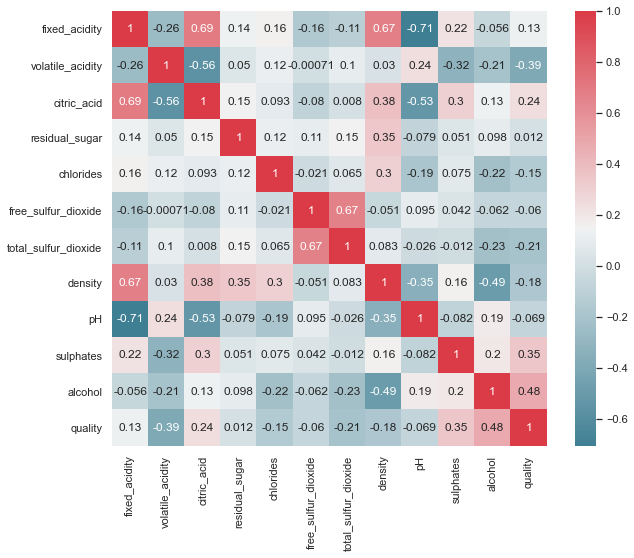

In [7]:
# Lineaire correlatie tussen de features - heatmap
dataset.corr()
# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(10,8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

In [8]:
dataset.corr()[['quality']].sort_values(by='quality', ascending = False)

,quality
quality,1.000000
alcohol,0.480800
sulphates,0.346915
citric_acid,0.239975
fixed_acidity,0.127083
residual_sugar,0.011987
free_sulfur_dioxide,-0.060042
pH,-0.068798
chlorides,-0.148943
density,-0.177606


- Welke features lijken het meest invloed te hebben op de kwaliteitsscore? 

De features alcohol, volatile acidity, sulphates, total sulfur dioxide en citric_acid hebben het meeste invloed op de kwaliteitsscore.

- Zijn er features die onderling sterk gecorreleerd zijn.

Ja, de volgende features zijn sterk gecorreleerd met elkaar.
- free sulfur dioxide en total sulfur dioxide
- alcohol en quality
- de acidity waarden zoals fixed acidity en citric acid waarden

Als je 5 features zou willen weglaten, welke zouden dit zijn? Verklaar waarom. Bij deze vraag is de verklaring belangrijk. (het hoogste en laagste features)

- fixed acidity
- density
- free sulfur dioxide
- ph
- citric acid

Ik heb de features weggelaten dat het meest gecorreleerd zijn (zowel positief en negatief). Dit betekent dat als 1 variabele stijgt dat het ander linear mee stijgt. Hoe dichter bij de 1, hoe sterker de relatie tussen de variabelen. Vice versa voor het negatieve. Het reden daarvoor is dat gecorreleerde features in het algemeen het model niet verbeteren. Daarom is het aangeraden om 1 van de 2 variabelen dat gecorreleerd zijn te verwijderen. Vervolgens versnelt dat ook het leren van de algoritme en maakt het makkelijker om het model te interpreteren.

- Maak een pairplot, bekijk deze aandachtig en formuleer enkele conclusies. Zijn er verbanden te leggen tussen wat je ziet op de pairplot en op de correlatie heatmap?


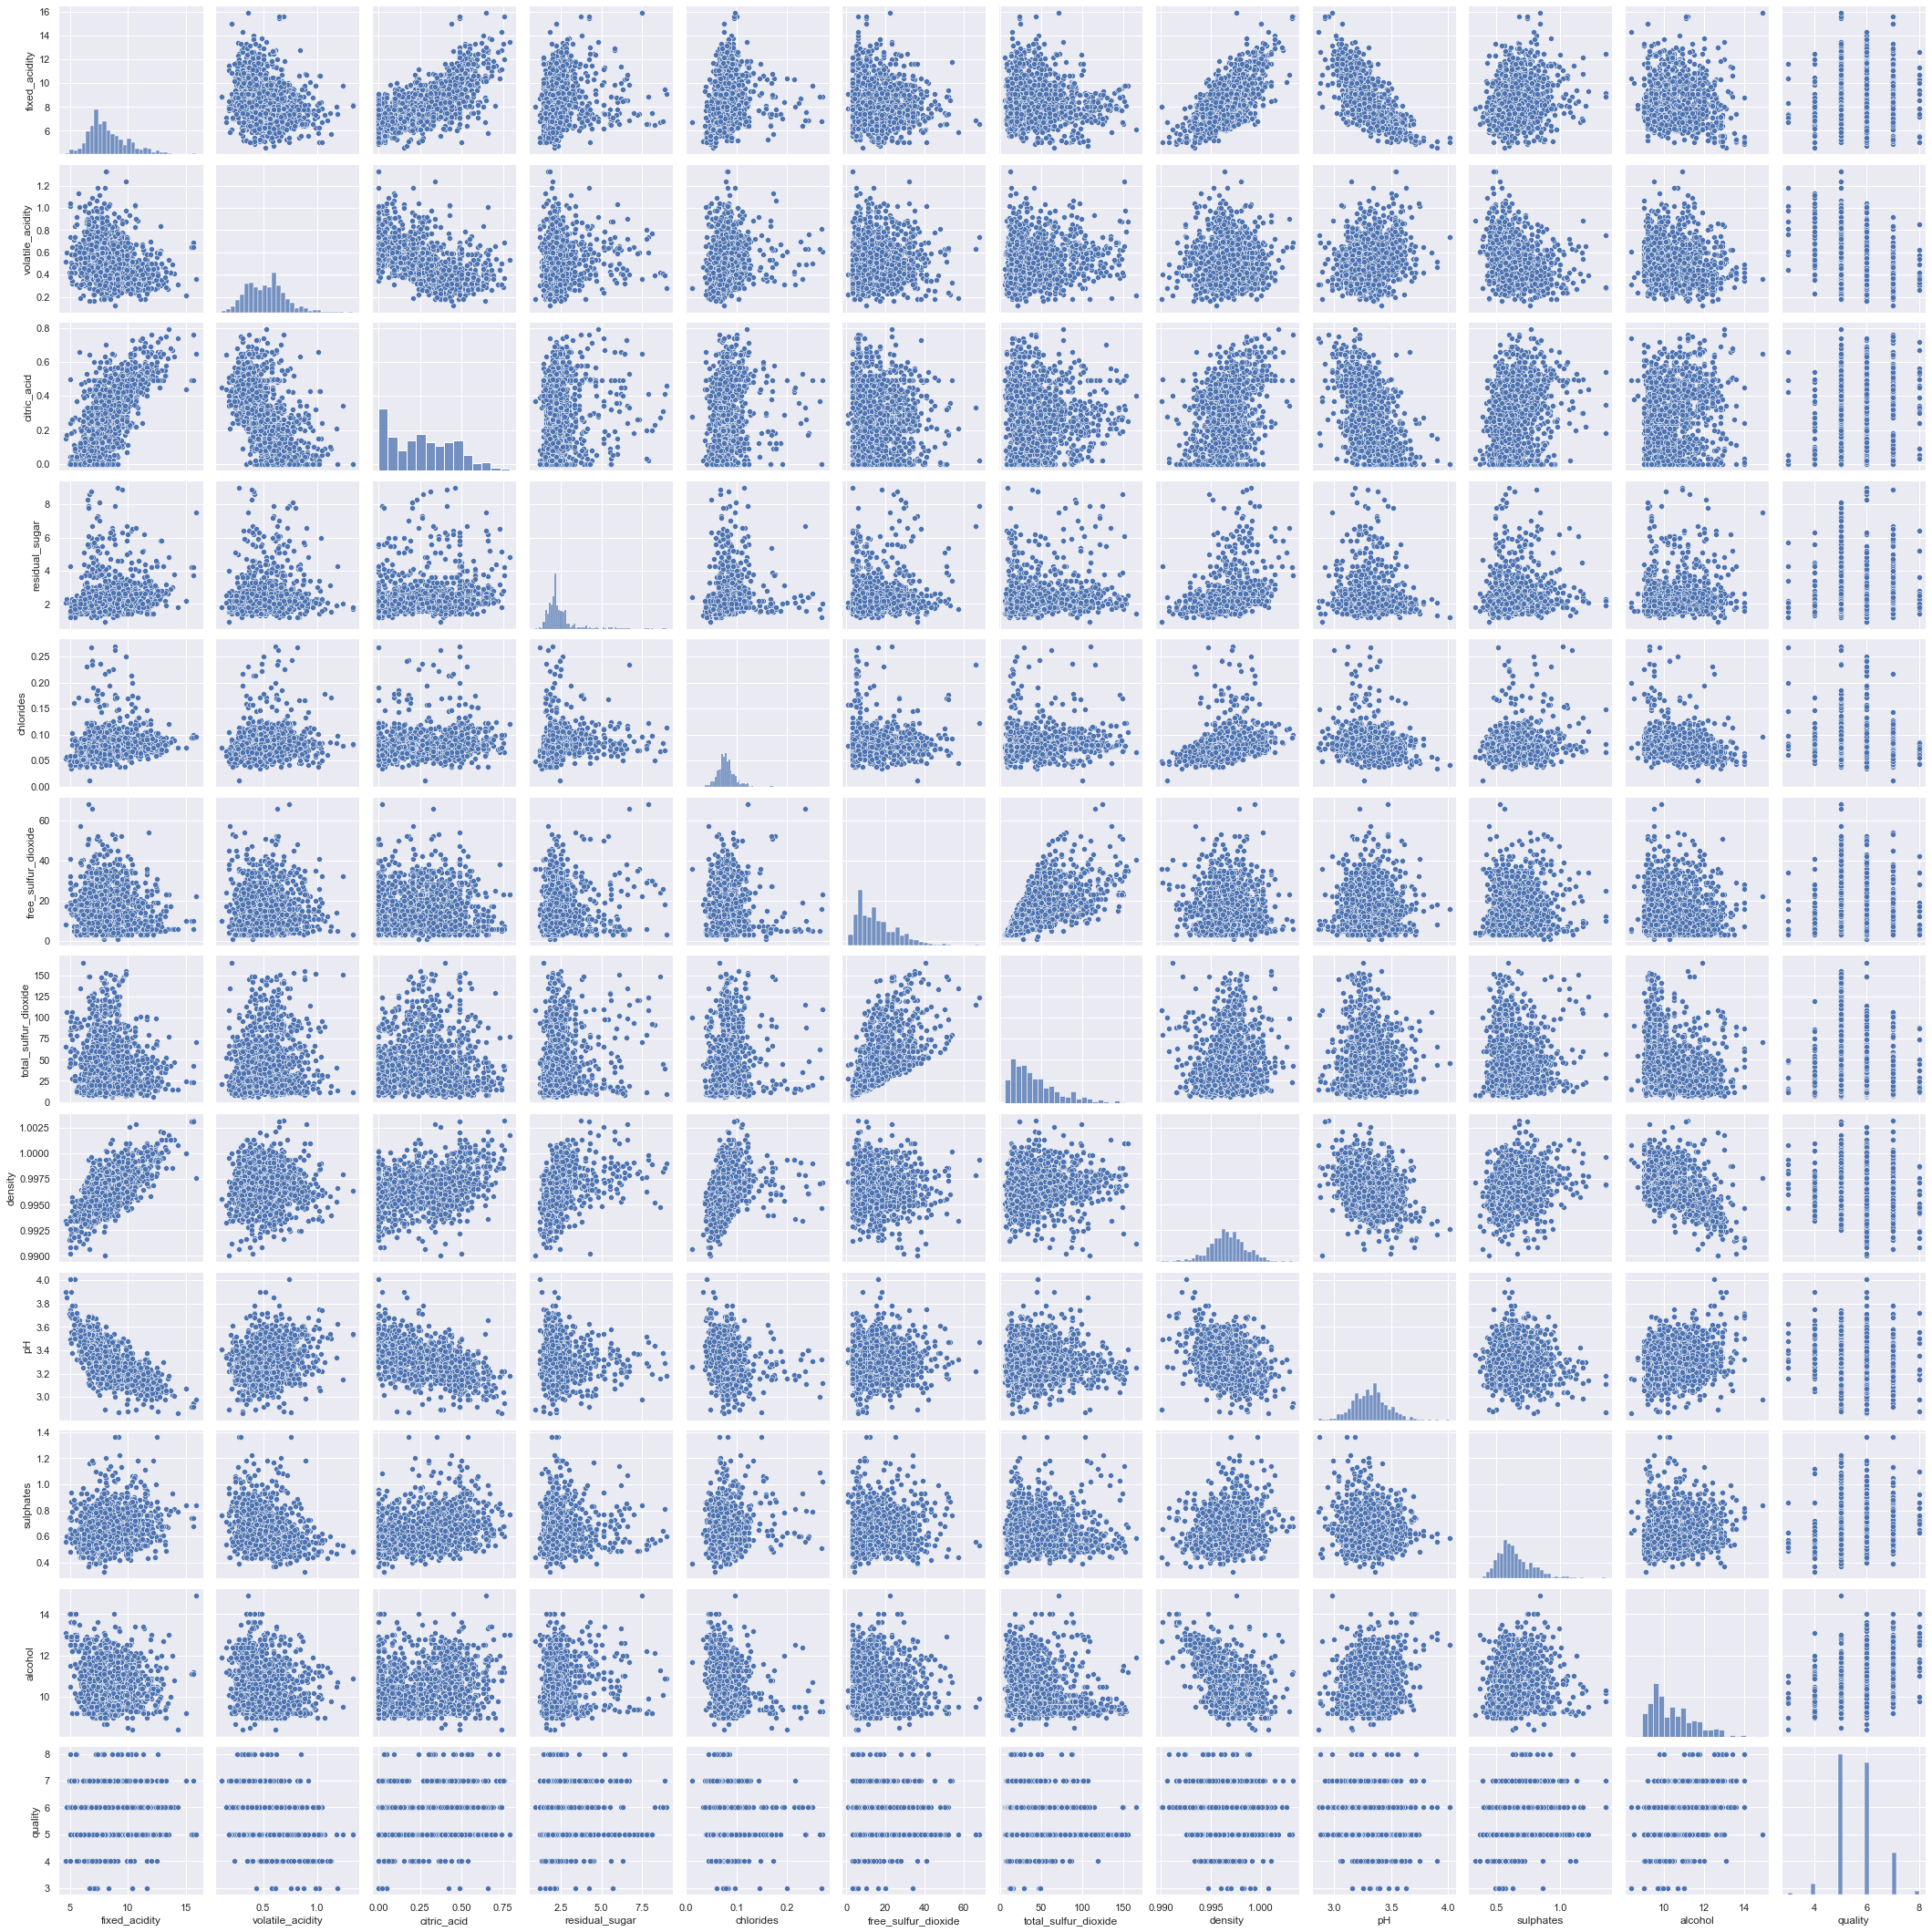

In [9]:
# Pairplot (=scatterplot). (Dit kan wat tijd vragen om te genereren)
sns.pairplot(dataset)
# Formuleer conclusies

Features dat een invloed heeft op de kwaliteit:

- alcohol
- sulphates
- volatile acidity
- total sulfur dioxide
- citric acid

Features dat geen impact heeft op de kwaliteit:
- Ph
- free sulfur dioxide
- residual sugar

Ja, er zijn verbanden tussen de pairplot en de heatmap. Bij positieve correlaties zien we dat het linear is op de pairplot.

De meeste features zijn normaalverdeeld. Een standardscaler zal in principe een goede keuze zijn.
De verbanden tussen de sterk gecorreleerde features zijn vrij lineair (de puntenwolk volgt vrij goed een denkbeeldige rechte).

### Opsplitsen van de dataset

Splits de dataset op in features X en targets y. Vervolgens kan je de dataset opsplitsen in een training set en een test set. Gebruik hiervoor de functie train_test_split van Sklearn (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Zorg dat er 30 procent van de dataset in de test set terecht komt.

Normaliseer de training set en de test set met een standardscaler. Probeer later ook met een robustscaler.
Verklaar wat het verschil is tussen de standardscaler en de robustscaler.
De labels hoeven niet genormaliseerd te worden.

In [10]:
# Dataset opsplitsen in features en target
features = list(dataset.columns[:dataset.columns.size-1])
X = dataset[features].values
y = dataset['quality'].values
print(y)
print(X)

[5 5 5 ... 6 5 6]
[[ 7.4    0.7    0.    ...  3.51   0.56   9.4  ]
 [ 7.8    0.88   0.    ...  3.2    0.68   9.8  ]
 [ 7.8    0.76   0.04  ...  3.26   0.65   9.8  ]
 ...
 [ 6.3    0.51   0.13  ...  3.42   0.75  11.   ]
 [ 5.9    0.645  0.12  ...  3.57   0.71  10.2  ]
 [ 6.     0.31   0.47  ...  3.39   0.66  11.   ]]


In [11]:
# Opsplitsen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
# Normaliseren van de training set en de test set
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

- Het verschil tussen standardscaler en robustscaler
    - De standarscaler gebruik je best bij normaal verdeel data met weinig uitschieters
    - De robustscaler gebruik je wanneer er veel uitschieters zijn

In [46]:
print(X_train.shape)
print(y_train.shape)

(265, 24)
(265,)


## Trainen van het regressiemodel

Train een regressiemodel via linear_model.LinearRegression(). Print vervolgens de coëfficiënten van het model. 

In [14]:
# Trainen van het regressiemodel
# initialiseren en trainen van het regressiemodel
lregmodel = linear_model.LinearRegression()
lregmodel.fit(X_train, y_train)

LinearRegression()

In [15]:
# print de coëfficiënten en de intercept van het model
print('coeffs: ', lregmodel.coef_)
print('intercept', lregmodel.intercept_)

coeffs:  [ 0.01531838 -0.15467062 -0.01316333 -0.00933081 -0.03797956  0.05128892
 -0.10805291 -0.03858042 -0.09261187  0.17189205  0.30065175]
intercept 5.637614678899104


### Testen en voorspellen
Voorspel de kwaliteitsscore van een wijn met chemische parameters:
									
fixed_acidity: 7.3 | 
volatile_acidity: 0.70 | citric_acid: 0.00 | residual_sugar: 1.9 | chlorides: 0.079 | free_sulfur_dioxide: 11.0 | total_sulfur_dioxide: 34.0 | density: 0.9978 | pH: 3.51 | sulphates: 0.58 | alcohol: 9.4

In [16]:
# Voorspelling van de kwaliteitsscore van de wijn.
wine = np.array([7.3, 0.70, 0, 1.9, 0.079, 11, 34, 0.9978, 3.51, 0.58, 9.4])

quality = lregmodel.predict(wine.reshape(1,-1))
print('De kwaliteit van de wijn bedraagt: ', quality)

De kwaliteit van de wijn bedraagt:  [5.07308023]


Evalueer het regressiemodel op basis van de MAE, MSE en de $R^2$-score. Gebruik hiervoor de test set. Formuleer een aantal conclusies uit deze scores.

In [17]:
# Evaluatie van het model via de MAE, MSE en de R2-score
y_predicted = lregmodel.predict(X_test)

# MAE
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test, y_predicted)
print('MAE = ', MAE)

# MSE
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, y_predicted)
print('MSE = ', MSE)

## coefficient of determination = r2 score
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_predicted)
print('r2 = ', r2)

MAE =  0.49495672818573416
MSE =  0.4041360368256535
r2 =  0.3700278895022885


R² score bedraagt 0.37. Dit betekent dat het voor 37% met nauwkeurigheid kan voorspellen. Het model is slecht en kan verbeterd worden.

- However, it does not take into consideration of overfitting problem. 

R Square/Adjusted R Square are better used to explain the model to other people because you can explain the number as a percentage of the output variability. MSE, RMSE or MAE are better to be used to compare performance between different regression models. Personally, I would prefer using RMSE and I think Kaggle also uses it to assess submission. However, it makes total sense to use MSE if value is not too big and MAE if you do not want to penalize large prediction error.
Adjusted R square is the only metric here that considers overfitting problem. R Square has direct library in Python to calculate but I did not find a direct library to calculate Adjusted R square except using the statsmodel results. If you really want to calculate Adjusted R Square, you can use statsmodel or use its mathematic formula directly.

-  MAE en de MSE verlaagd worden en de R2 score toeneemt.

### Modeloptimalisatie
Probeer de performantie van het model te verbeteren. Zorg er met andere woorden voor dat de MAE en de MSE verlaagd worden en de $R^2$ score toeneemt.
Mogelijke opties zijn:
- Toevoegen van hogere orde features (manueel). Motiveer waarom je bepaalde hogere orde features zou gebruiken. Kijk hiervoor bijvoorbeeld naar de pairplot of de correlatie heatmap (ga op zoek naar niet-lineariteiten).
- Extra features afleiden uit de bestaande features.
- Toepassen van regularisatie via Ridge regression en Lasso regression. Ga telkens op zoek naar een goede waarde voor alpha. 
- Ga telkens na of er overfitting over underfitting optreedt. Doe dit door de performantie op de training set te vergelijken met de performantie op de test set. 
- Voeg automatisch hogere orde features toe via sklearn.preprocessing.PolynomialFeatures. Ga niet hoger dan 3de of 4de orde. Het aantal features neemt namelijk exponentiëel toe met de orde met als gevolg dat het model niet meer binnen een aanneembare tijd te trainen valt.

Motiveer telkens de gemaakte keuze en evalueer het model met de test set. Wat is de beste performantie die je haalt? **Bespreek het eindresultataat**.

In [18]:
# L2 regularisatie toepassen via Ridge regression

lregmodel = Ridge(alpha=40, tol=0.0001, fit_intercept=True)
lregmodel.fit(X_train, y_train)

# r2 score
lregmodel.score(X_test, y_test)

0.3694722079897199

In [19]:
# L1 regularisatie toepassen via Lasso regression

lregmodel = Lasso(alpha=0.1, tol=0.0001, fit_intercept=True)
lregmodel.fit(X_train, y_train)
lregmodel.score(X_test, y_test)

0.3209353696174063

In [20]:
# Modeloptimalisatie en Hyperparameter tuning
from sklearn.preprocessing import PolynomialFeatures

# Aanmaken van de hogere orde features
graad = 3

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ', X_train_poly.shape)
print('dimensie van X_test_poly: ', X_test_poly.shape)

# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=1000, tol=0.0001, fit_intercept=True)
lregmodel_poly.fit(X_train_poly, y_train)

print('R2 score via L2: ',lregmodel_poly.score(X_test_poly,y_test))

# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))

# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=0.015,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train))

dimensie van X_train_poly:  (1090, 364)
dimensie van X_test_poly:  (468, 364)
R2 score via L2:  0.409159841488421
R2 score op training set via L2:  0.49240188918831485
R2 score via L1:  0.4086895646425197
R2 score op training set via L1:  0.5016751143351179


Voor de performatie te verbeteren heb ik de optie van polynomialfeatures gekozen om mij te helpen. De reden is omdat het automatisch gebeurt. Vervolgens heb ik geen kennis van het domein (wijnen). Daarom is het best om samen met een domein expert samen te werken als je de features manueel wilt aanpassen.

Aan de hand van de resultaten kan ik besluiten dat het gebruik van polynomial features het model heeft verbeterd.

## 2. Bierconsumptie

In het bestand *beerconsumption.csv* vind je een dataset met gegevens over de dagelijkse bierconsumptie in en een bepaalde stad (van het jaar 2015) in functie van de datum en de weersomstandigheden.
Bedoeling is om een regressiemodel te vinden dat een zo accuraat mogelijke voorspelling kan doen van de te verwachten bierconsumptie op een zekere dag met bepaalde te verwachten weersomstandigheden.

De verschillende features omvatten:
- date: datum
- average_temp: gemiddelde temperatuur van die dag in graden Celcius
- min_temp: minimum temperatuur van die dag in graden Celcius
- max_temp: maximum temperatuur van die dag in graden Celcius
- precipitation: de hoeveelheid neerslag in mm
- weekend: binaire variabele (0/1) die aanduidt of het al dan niet weekend is

De te voorspellen variabele (target) is 'consumption', de totale dagelijkse bierconsumptie in liter.


**Opdracht:**

- Controleer de dataset op inconsistenties: ontbrekende waarden, foutieve en extreme waarden
- Voeg twee kolommen toe aan de dataset. Noem deze kolommen 'month' en 'day'. In de ene kolom komt de naam van de maand (January, February, March, ...), in de andere de naam van de dag van de week (Monday, Tuesday, ...). Zoek online hoe je uit de datum de maandnaam en dagnaam kan halen. Verwijder vervolgens de 'date' kolom. Deze hebben we niet meer nodig.
- Vooranalyse: visualiseer de bierconsumptie per maand, bijvoorbeeld via boxplots (https://seaborn.pydata.org/generated/seaborn.boxplot.html). In welke maand wordt het meest bier geconsumeerd en in welke maand het minst? Visualiseer ook de bierconsumptie per dag. Op welke dagen van de week wordt het meest bier geconsumeerd en op welke dag het minst.

- Pas one-hot encoding toe op de features 'month' en 'day'. Zo worden categorische variabelen omgezet naar numerieke one-hot variabelen. Meer info over one-hot encoding is te vinden op https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b.

- Splits op in features en targets en maak vervolgens een training set en test set aan. Zorg ervoor dat er 100 samples in de test set zitten.

- Normaliseer de features. Categorische variabelen hoeven niet genormaliseerd te worden. Baseer je op de histogrammen om te beslissen welke normalisatie je zal toepassen (Standardscaler, MinMaxscaler of Robustscaler). De MinMaxscaler laat one-hot variabelen onveranderd.

- Train een regressiemodel

- Test het getraind model op de test set

- Doe optimalisaties en hyperparameter tuning om de performantie van het model (op de test set) te verhogen. Maak een grafiek van de r²-score in functie van de regularisatieparameter alpha.

- Bespreek het finaal bekomen model. Wat is de R²-score? Wat is de betekenis ervan? Wat zegt de bekomen MAE? Ga ook na welke twee features de grootste invloed hebben op de bierconsumptie.

- Zijn er features die je mag weglaten? Met andere woorden, zijn er overbodige features? Argumenteer.

- Voorspel de bierconsumptie op een zondag in juni bij een gemiddelde temperatuur van 28.64 graden, een min_temp van 25.22 en een max_temp van 31.08. Er is geen neerslag.



- Controleer de dataset op inconsistenties: ontbrekende waarden, foutieve en extreme waarden

In [22]:
df = pd.read_csv('beerconsumption.csv')
df

,date,average_temp,min_temp,max_temp,precipitation,weekend,consumption
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900
...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,1,32307
361,2015-12-28,22.64,21.1,26.7,0.0,0,26095
362,2015-12-29,21.68,20.3,24.1,10.3,0,22309
363,2015-12-30,21.38,19.3,22.4,6.3,0,20467


In [23]:
print(df.shape)

(365, 7)


In [24]:
df.head()

,date,average_temp,min_temp,max_temp,precipitation,weekend,consumption
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900


In [25]:
print(df.dtypes)

date              object
average_temp     float64
min_temp         float64
max_temp         float64
precipitation    float64
weekend            int64
consumption        int64
dtype: object


In [26]:
# Ga na of de dataset ontbrekende waarden bevat
dataset.isnull().sum()
# er zijn geen ontbrekende waarden

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [27]:
df.describe()

,average_temp,min_temp,max_temp,precipitation,weekend,consumption
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25401.367123
std,3.180108,2.826185,4.317366,12.417844,0.452001,4399.142703
min,12.900000,10.600000,14.500000,0.000000,0.000000,14343.000000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22008.000000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24867.000000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28631.000000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37937.000000


Voeg twee kolommen toe aan de dataset. Noem deze kolommen 'month' en 'day'. In de ene kolom komt de naam van de maand (January, February, March, ...), in de andere de naam van de dag van de week (Monday, Tuesday, ...). Zoek online hoe je uit de datum de maandnaam en dagnaam kan halen. Verwijder vervolgens de 'date' kolom. Deze hebben we niet meer nodig.

In [28]:
df['date'] = pd.to_datetime(df['date'])
df['date']
# month
df['month'] = df['date'].dt.strftime('%B')
# day
df['day'] = df['date'].dt.strftime('%A')

# delete date column
df = df.drop(['date'], axis=1)
df

,average_temp,min_temp,max_temp,precipitation,weekend,consumption,month,day
0,27.30,23.9,32.5,0.0,0,25461,January,Thursday
1,27.02,24.5,33.5,0.0,0,28972,January,Friday
2,24.82,22.4,29.9,0.0,1,30814,January,Saturday
3,23.98,21.5,28.6,1.2,1,29799,January,Sunday
4,23.82,21.0,28.3,0.0,0,28900,January,Monday
...,...,...,...,...,...,...,...,...
360,24.00,21.1,28.2,13.6,1,32307,December,Sunday
361,22.64,21.1,26.7,0.0,0,26095,December,Monday
362,21.68,20.3,24.1,10.3,0,22309,December,Tuesday
363,21.38,19.3,22.4,6.3,0,20467,December,Wednesday


- Vooranalyse: visualiseer de bierconsumptie per maand, bijvoorbeeld via boxplots (https://seaborn.pydata.org/generated/seaborn.boxplot.html). In welke maand wordt het meest bier geconsumeerd en in welke maand het minst? Visualiseer ook de bierconsumptie per dag. Op welke dagen van de week wordt het meest bier geconsumeerd en op welke dag het minst.

<AxesSubplot:xlabel='month', ylabel='consumption'>

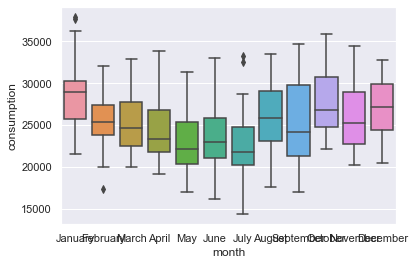

In [29]:
# boxplot bierconsumptie per maand
sns.boxplot(x=df['month'], y=df['consumption'])
# meeste consumptie: oktober
# minste consumptie: july

<AxesSubplot:xlabel='day', ylabel='consumption'>

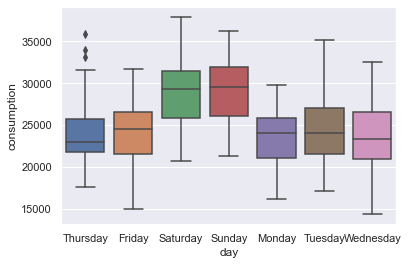

In [30]:
# boxplot bierconsumptie per dag
sns.boxplot(x=df['day'],y=df['consumption'])
# meeste consumptie per dag: sunday
# minste consumptie per dag: monday

- Pas one-hot encoding toe op de features 'month' en 'day'. Zo worden categorische variabelen omgezet naar numerieke one-hot variabelen. Meer info over one-hot encoding is te vinden op https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b.

In [31]:
df = pd.concat([df, pd.get_dummies(df['month'])], axis=1)
df.drop(['month'], axis=1, inplace=True)
df = pd.concat([df, pd.get_dummies(df['day'])], axis=1)
df.drop(['day'], axis=1, inplace=True)
df.head()

,average_temp,min_temp,max_temp,precipitation,weekend,consumption,April,August,December,February,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,27.30,23.9,32.5,0.0,0,25461,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,27.02,24.5,33.5,0.0,0,28972,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,24.82,22.4,29.9,0.0,1,30814,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,23.98,21.5,28.6,1.2,1,29799,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,23.82,21.0,28.3,0.0,0,28900,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


- Splits op in features en targets en maak vervolgens een training set en test set aan. Zorg ervoor dat er 100 samples in de test set zitten

In [32]:
# Dataset opsplitsen in features en target
y = df.consumption.values
X = df.drop(['consumption'], axis=1).values


In [33]:
# Opsplitsen in trainingset en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=0)

- Normaliseer de features. Categorische variabelen hoeven niet genormaliseerd te worden. Baseer je op de histogrammen om te beslissen welke normalisatie je zal toepassen (Standardscaler, MinMaxscaler of Robustscaler). De MinMaxscaler laat one-hot variabelen onveranderd.

In [34]:
scaler = preprocessing.StandardScaler().fit(X_train) 

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

- Train een regressiemodel

In [35]:
# initaliseren en trainen van het regressiemodel
lregmodel = linear_model.LinearRegression()
lregmodel.fit(X_train, y_train)

# Coëfficiënten en intercept van het lineair regressiemodel
print('coeffs: ',lregmodel.coef_)
print('intercept', lregmodel.intercept_)

coeffs:  [ 4.06066998e+02 -7.52523575e+01  2.71993737e+03 -7.72542331e+02
  2.32533936e+16 -1.01269175e+14 -9.90309061e+13 -1.13407839e+14
 -1.01269175e+14 -1.03439685e+14 -1.07593703e+14 -1.11521432e+14
 -9.90309061e+13 -9.67201735e+13 -1.01269175e+14 -1.03439685e+14
 -1.03439685e+14  4.16756696e+16  4.26631513e+16  2.45451734e+16
  2.39770506e+16  4.49533149e+16  4.26631513e+16  4.49533149e+16]
intercept 25237.14856136761


- Test het getraind model op de test set

In [36]:
# Evaluatie van het model

y_predicted = lregmodel.predict(X_test)

## Mean Absolute Error
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test,y_predicted)
print('MAE = ',MAE)

## Mean Squared Error
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test,y_predicted)
print('MSE = ',MSE)

## coefficient of determination = r2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_predicted)

print('r2 score = ',r2)

MAE =  1998.1170287726482
MSE =  5556466.758451024
r2 score =  0.6683991852119462


- Doe optimalisaties en hyperparameter tuning om de performantie van het model (op de test set) te verhogen. Maak een grafiek van de r²-score in functie van de regularisatieparameter alpha.

In [37]:
# L2 regularisatie toepassen via Ridge regression

lregmodel = Ridge(alpha=40, tol=0.0001, fit_intercept=True)
lregmodel.fit(X_train, y_train)

# r2 score
lregmodel.score(X_test, y_test)

0.65912008291521

In [38]:
# L1 regularisatie toepassen via Lasso regression

lregmodel = Lasso(alpha=0.1, tol=0.0001, fit_intercept=True)
lregmodel.fit(X_train, y_train)
lregmodel.score(X_test, y_test)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35646366.40608251, tolerance: 533952.873437736
  model = cd_fast.enet_coordinate_descent(


0.6646476737720551

In [39]:
# Automatisch toevoegen van hogere orde features

from sklearn.preprocessing import PolynomialFeatures

# Aanmaken van de hogere orde features

graad = 3

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)

# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=6000,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score via L2: ',lregmodel_poly.score(X_test_poly,y_test))

# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))

# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=500,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train))    
  

dimensie van X_train_poly:  (265, 2925)
dimensie van X_test_poly:  (100, 2925)
R2 score via L2:  0.5765807442883493
R2 score op training set via L2:  0.7712985752786189
R2 score via L1:  0.6113893754191815
R2 score op training set via L1:  0.7589722908319079


In [40]:
# Maak een grafiek van de r²-score in functie van de regularisatieparameter alpha


- Bespreek het finaal bekomen model. Wat is de R²-score? Wat is de betekenis ervan? Wat zegt de bekomen MAE? Ga ook na welke twee features de grootste invloed hebben op de bierconsumptie.

In [41]:
df.corr()[['consumption']].sort_values(by='consumption', ascending = False)

,consumption
consumption,1.000000
max_temp,0.642672
average_temp,0.574615
weekend,0.505981
min_temp,0.392509
Sunday,0.334581
Saturday,0.318846
January,0.227204
October,0.156160
December,0.122618


- Wat is de R²-score? Wat is de betekenis ervan?

    - R2 score via L2:  0.5765807442883493
    - R2 score op training set via L2:  0.7712985752786189
    - R2 score via L1:  0.6113893754191816
    - R2 score op training set via L1:  0.7589722908319079
- Wat zegt de bekomen MAE?
    - Dat het gemiddelde absolute fout 2009 bedraagt

- Ga ook na welke twee features de grootste invloed hebben op de bierconsumptie
    - De twee grootste features die een grote invloed hebben zijn max_temp en average_temp

- Voorspel de bierconsumptie op een zondag in juni bij een gemiddelde temperatuur van 28.64 graden, een min_temp van 25.22 en een max_temp van 31.08. Er is geen neerslag.

In [42]:
behaviour =np.array([28.64, 25.22, 31.08, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

beerConsumption = lregmodel.predict(behaviour.reshape(1,-1))
print('De gemiddelde bierconsumptie op zondag in juni bedraagt: ' , beerConsumption)




De gemiddelde bierconsumptie op zondag in juni bedraagt:  [122017.30021267]


In [43]:
# volledige koloms te laten zien
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df.columns.tolist())

['average_temp', 'min_temp', 'max_temp', 'precipitation', 'weekend', 'consumption', 'April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
